In [1]:
import os 
data_dir = "./data/"


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Parse data into dict of dicts 
algs = {}
data_dir = "data/"
for d in os.listdir(data_dir):
    if d.startswith(".") or d.endswith("gz") or d.endswith("txt") or d=="tm-seqid": continue
    algs[d] = dict()
    for f in os.listdir(data_dir + d):
        if f.endswith("DS_Store") or f.endswith("txt") : continue
        pn = 0 if "pos" in f.lower() else 1 if "neg" in f.lower() else None
        if pn is None:
            raise FileNotFoundError("File {} not found".format(f))
        fname = data_dir + d + "/" + f
        s = "_".join(f.split("-")[0:2]).lower() if "apoc" in f.lower() else f.split("-")[0].lower()
        s = "hoffman" if s.lower().startswith("hoff") else s
        
        if not s in algs[d]:
            algs[d][s] = [None, None]
        algs[d][s][pn] = fname

In [ ]:
from numpy import trapz

def AU_thr_fxn(actual, scores, fxns, alpha = 0.01):
    """
    Calculates the area under the function-threshold curve for actual&scores. <br>
    The y-value of the function-threshold curve is a function (in fxns) of actual, scores at the corresponding threshold (x-value). <br>
    This is calculated for all thresholds in the range of scores in steps of alpha. 
    
    actual: numpy.array
    scores: numpy.array
    fxns: list of sklearn.metrics functions to apply on actual&scores 
    """
    
    # normalize scores to ensure default alpha won't break 
    scores = scores/scores.max()
    
    # apply scores over threshold space 
    fscores = {}
    for thr in np.arange(min(scores)-alpha, max(scores)+alpha, alpha):
        fscores[thr]={}
        for fxn in fxns: 
            fscores[thr][fxn.__name__] = (fxn(actual, scores>thr))
    
    # calculate AU-fxn(thr) 
    reduced_scores = {}
    thrs = np.array(list(fscores.keys()))
    for fxn in fxns:
        fthrs = np.array([fscores[t][fxn.__name__] for t in thrs])
        reduced_scores[fxn.__name__] = trapz(fthrs, np.array(thrs), axis=0)
    return reduced_scores


In [ ]:
# demonstration of above 
def abc(a,b):
    return sum(a)
AU_thr_fxn(np.array([1,2,3]),np.array([1,2,3]), [abc])

In [17]:
from sklearn.metrics import accuracy_score, precision_score, matthews_corrcoef

functions_to_apply = [accuracy_score, precision_score, matthews_corrcoef]

In [139]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve

fxns = dict() # all single-valued data 
rocs = dict() # roc curves 
pvrs = dict() # pre-rec curves 
raws = dict() # actuals, scores 

for alg in algs:
    print(alg)
    fxns[alg] = dict()
    rocs[alg] = dict()
    pvrs[alg] = dict()
    raws[alg] = dict()
    
    for dataset in algs[alg]:
        scores = []
        with open(algs[alg][dataset][0]) as file_P: 
            positives = 0
            for i, v in enumerate(file_P):
                try:
                    scores.append(float(v.split()[-1]))
                    positives += 1
                except ValueError: 
                    continue
        
        with open(algs[alg][dataset][1]) as file_N: 
            negatives = 0
            for i, v in enumerate(file_N):
                try:
                    scores.append(float(v.split()[-1]))
                    negatives += 1
                except ValueError: 
                    continue
                    
        actual = [1]*positives + [0]*negatives

        fpr, tpr, thr_roc = roc_curve(actual, scores)
        pre, rec, thr_pvr = precision_recall_curve(actual, scores)
        
        fxns[alg][dataset] = AU_thr_fxn(np.array(actual), np.array(scores), functions_to_apply)
        fxns[alg][dataset]["roc_auc"] = auc(fpr,tpr)
        fxns[alg][dataset]["pvr_auc"] = np.trapz(rec, pre)
        
        rocs[alg][dataset] = (fpr, tpr, thr_roc)
        pvrs[alg][dataset] = (pre, rec, thr_pvr)
        raws[alg][dataset] = (actual, scores)

ematchsite
tm
glosa
seqid
volume
pocketalign


In [140]:
# These are all the metrics you can use for spider plots 

print(list(fxns["tm"]["atp"].keys()))

['accuracy_score', 'precision_score', 'matthews_corrcoef', 'roc_auc', 'pvr_auc']


In [141]:
import pandas as pd
df = pd.DataFrame(fxns)

def getTable(fxn="roc_auc"):
    return pd.DataFrame({k1:{k2:v2[fxn] for k2, v2 in v1.iteritems()} for k1,v1 in df.iteritems()})

roc_auc = getTable()
pvr_auc = getTable("pvr_auc")
acc = getTable("accuracy_score")
mcc = getTable("matthews_corrcoef")
ppv = getTable("precision_score")

In [142]:
roc_auc

,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.888142,0.749094,0.765578,0.749993,0.467545,0.861577
apoc_lpc,0.888142,0.743877,0.902920,0.742628,0.393452,0.974444
atp,0.796213,0.421801,0.711513,0.527644,0.374611,0.827861
cyp,0.747666,0.910502,0.913020,0.928240,0.372138,0.921929
hoffman,0.709484,0.572589,0.599209,0.585089,0.467512,0.601051
huang,0.616432,0.526332,0.563701,0.534687,0.419547,0.620441
ito138,0.748079,0.483662,0.599826,0.560236,0.431149,0.691654
kahraman,0.634519,0.509979,0.487326,0.546112,0.430555,0.510203
soippa,0.810250,0.505964,0.207622,0.594023,0.429761,0.833786
steroid,0.423622,0.681633,0.831566,0.502527,0.548285,0.749267


In [143]:
pvr_auc

,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.431393,0.236077,0.225962,0.240794,-0.036665,0.311487
apoc_lpc,0.431393,0.273788,0.435544,0.279728,-0.081724,0.458552
atp,0.386711,0.044238,0.189845,0.036503,-0.044320,0.324448
cyp,0.039655,0.056794,0.058910,0.059239,-0.037674,0.056758
hoffman,0.212540,0.141078,0.185111,0.153166,-0.003532,0.205856
huang,0.071855,0.033453,0.061117,0.038154,-0.018215,0.134765
ito138,0.110701,0.021482,0.067038,0.037389,-0.014450,0.146181
kahraman,0.102362,0.008190,-0.004290,0.016908,-0.017380,0.003935
soippa,0.317934,0.040992,-0.131356,0.099344,-0.054623,0.289846
steroid,-0.000614,0.015748,0.004990,0.011938,0.000671,0.005345


In [144]:
acc

,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.838147,0.495560,0.360670,0.490670,0.425205,0.422002
apoc_lpc,0.838147,0.550857,0.520803,0.520829,0.484415,0.514156
atp,0.815803,0.609725,0.602467,0.813544,0.651766,0.829372
cyp,0.535584,0.717351,0.631295,0.319755,0.133319,0.076784
hoffman,0.846711,0.651780,0.585332,0.826818,0.680119,0.886022
huang,0.768209,0.672110,0.614414,0.855959,0.696560,0.899043
ito138,0.630826,0.627588,0.574390,0.865437,0.720313,0.913727
kahraman,0.730724,0.648515,0.656510,0.788840,0.700900,0.803662
soippa,0.754712,0.470241,0.411309,0.466594,0.456563,0.450255
steroid,0.873243,0.744667,0.734831,0.942942,0.799175,1.002049


In [145]:
mcc

,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.678594,0.175350,0.092421,0.142511,-0.052039,0.003553
apoc_lpc,0.678594,0.184485,0.188235,0.055547,-0.069750,0.082564
atp,0.527755,0.024919,0.134751,0.059694,-0.081904,0.070367
cyp,0.183775,0.270525,0.149658,0.145244,-0.045557,0.000208
hoffman,0.355704,0.130082,0.097842,0.103663,-0.009289,0.116616
huang,0.156000,0.047441,0.071885,0.068621,-0.038940,0.071922
ito138,0.243982,0.034663,0.054831,0.043880,-0.029624,0.049139
kahraman,0.186139,0.000636,-0.008784,0.002723,-0.025658,0.000560
soippa,0.551873,0.029222,-0.175356,0.022947,-0.061683,0.031737
steroid,-0.015146,0.055963,0.019557,0.018519,0.004900,-0.000556


In [146]:
ppv

,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.888565,0.829856,0.607551,0.924837,0.257013,0.998771
apoc_lpc,0.888565,0.814778,0.738535,0.964708,0.181077,1.005527
atp,0.642237,0.563992,0.597926,0.859547,0.079585,0.995380
cyp,0.991406,0.972387,0.978273,0.999216,0.626833,1.004054
hoffman,0.432831,0.393161,0.487079,0.761283,0.096904,0.875081
huang,0.222899,0.273080,0.383521,0.499219,0.071550,0.900543
ito138,0.181334,0.267677,0.314022,0.764620,0.055995,0.941569
kahraman,0.252389,0.082995,0.086408,0.046779,0.133429,0.107525
soippa,0.925320,0.748117,0.615721,0.957413,0.317481,0.995413
steroid,0.000417,0.046854,0.006058,0.020254,0.003248,0.000043


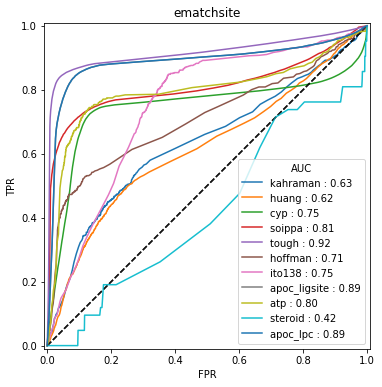

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


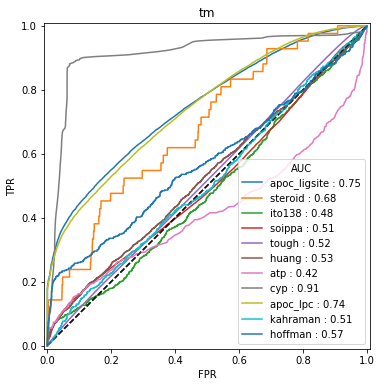

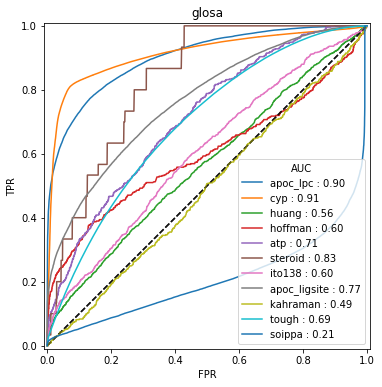

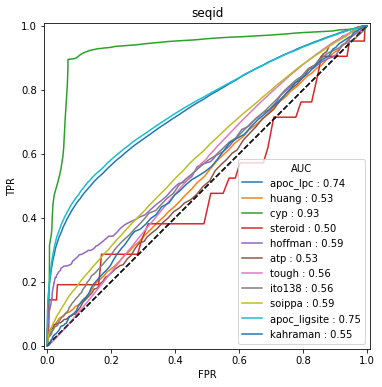

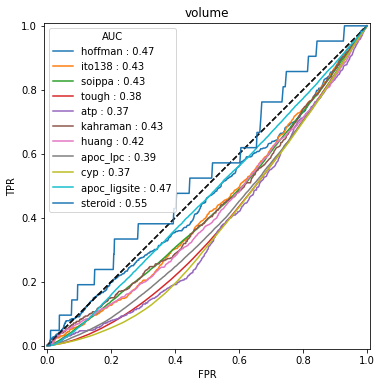

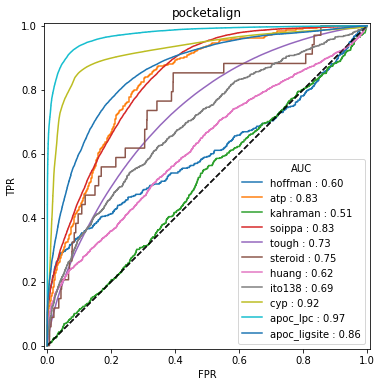

In [147]:
# ROC Curves per metric 
for metric in rocs:
    fig = plt.figure(figsize=(6,6)) # default is (8,6)
    ax = fig.add_subplot(111, aspect='equal')
    for dataset,(fpr, tpr, thrs) in rocs[metric].items():
        AUC = roc_auc[metric][dataset]
        ax.plot(fpr,tpr, label=dataset+" : %.2f"%(AUC))
        ax.plot(fpr,fpr,"k--",alpha=.2)
        
        ax.set_title(metric)
        ax.legend(title="AUC")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(-0.01,1.01)
        
    #plt.savefig("%s.png"%dataset)
    plt.show()

apoc_ligsite


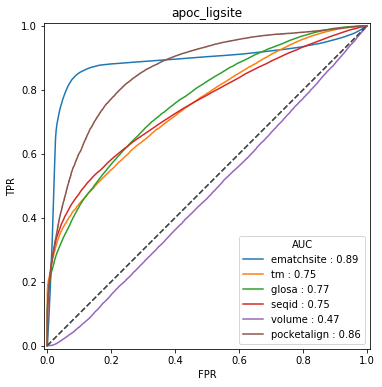

apoc_lpc


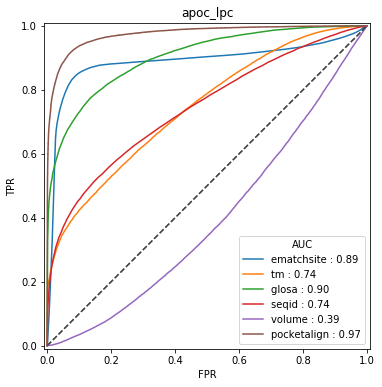

atp


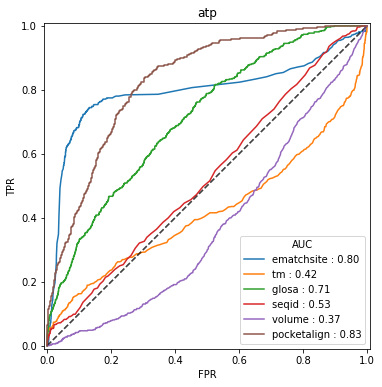

cyp


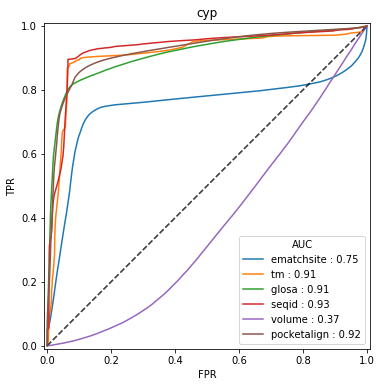

hoffman


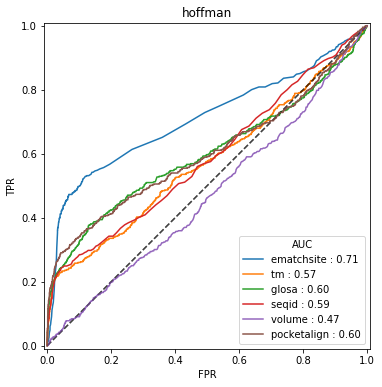

huang


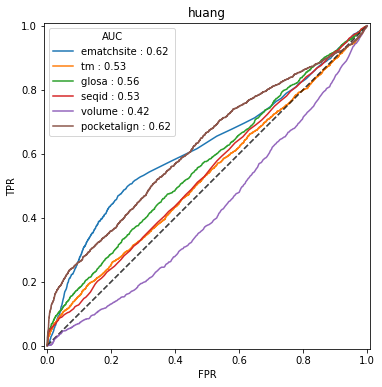

ito138


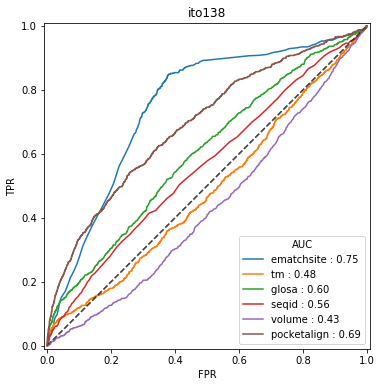

kahraman


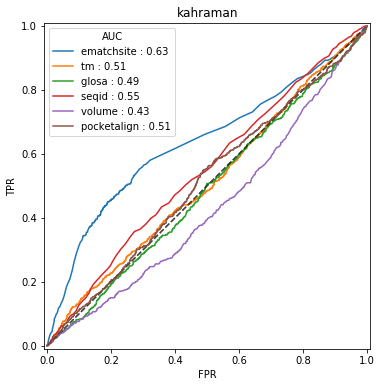

soippa


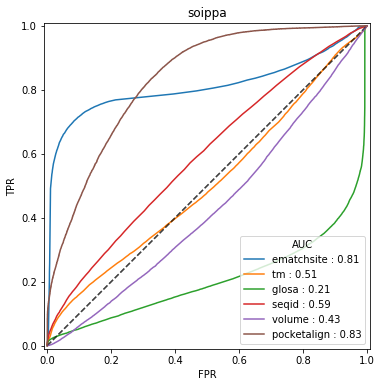

steroid


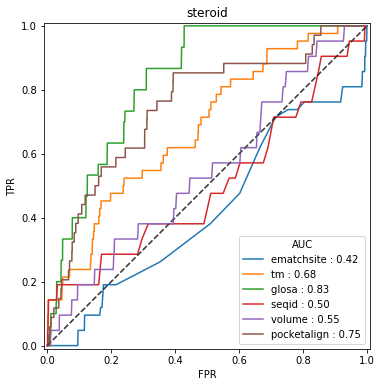

tough


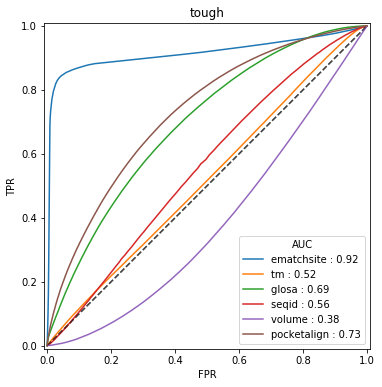

In [148]:
# ROC curves per dataset
rocs = pd.DataFrame(rocs).T.to_dict()
for dataset in rocs:
    fig = plt.figure(figsize=(6,6)) # default is (8,6)
    ax = fig.add_subplot(111, aspect='equal')
    for alg,(fpr, tpr, thrs) in rocs[dataset].items():
        AUC = roc_auc[alg][dataset]
        ax.plot(fpr,tpr, label=alg+" : %.2f"%(AUC))
        ax.plot(fpr,fpr,"k--",alpha=.2)
        
        ax.set_title(dataset)
        ax.legend(title="AUC")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(-0.01,1.01)
        
    #plt.savefig("%s.png"%dataset)
    print(dataset)
    plt.show()

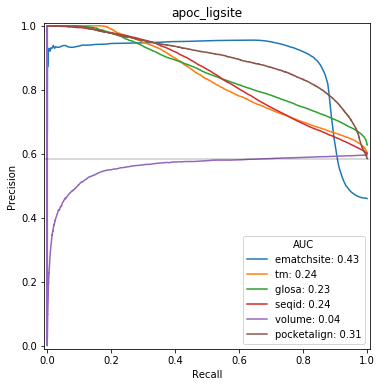

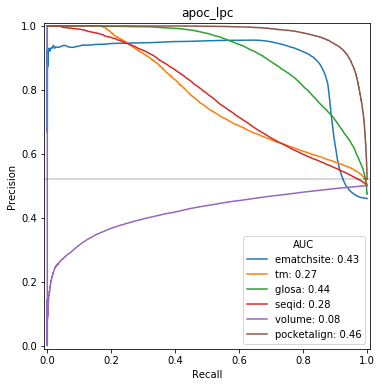

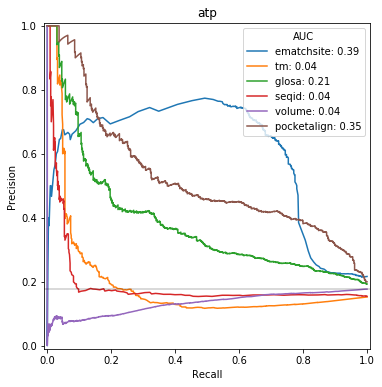

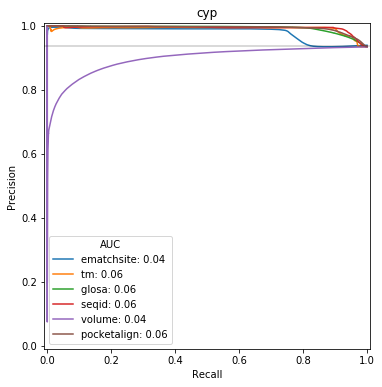

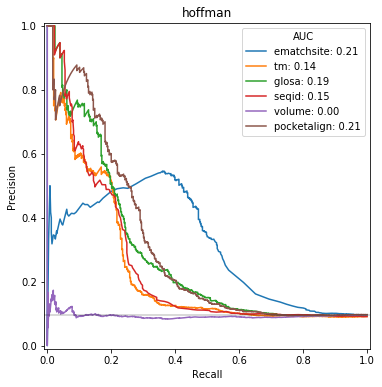

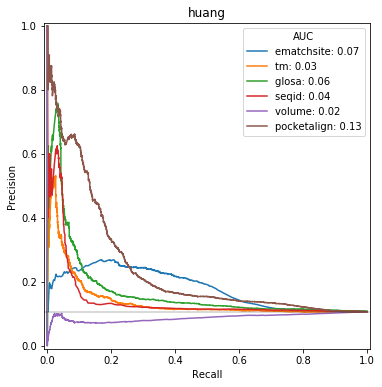

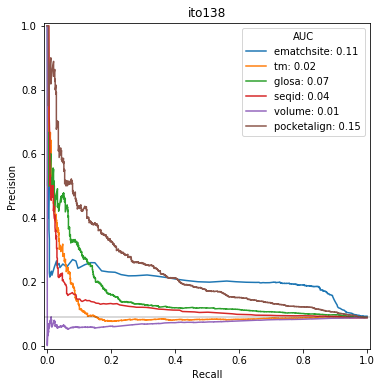

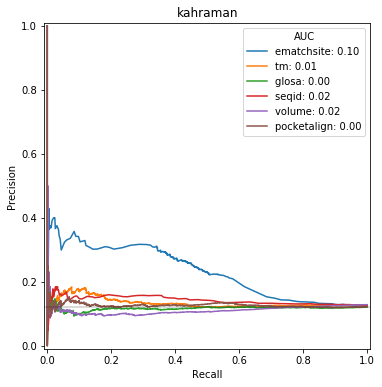

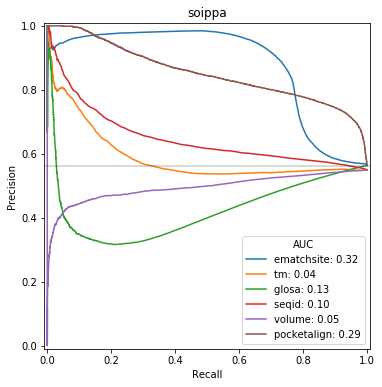

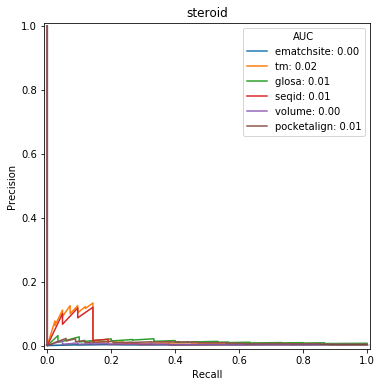

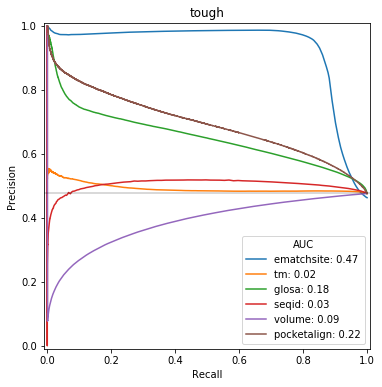

In [149]:
pvrs = pd.DataFrame(pvrs).T.to_dict()
for dataset in pvrs:
    fig = plt.figure(figsize=(6,6)) # default is (8,6)
    ax = fig.add_subplot(111, aspect='equal')
    for alg,(pre,rec,thrs) in pvrs[dataset].items():
        (actual, scores) = raws[alg][dataset]
        proportion = sum(actual)/len(actual)
        
        AUC = np.abs(proportion-auc(rec,pre))
        ax.plot(rec,pre,label=alg+": %.2f"%(AUC))
        
        ax.legend(title="AUC")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_xlim(-0.01,1.01)
        ax.set_ylim(-0.01,1.01)
        ax.set_title(dataset)
        
    ax.axhline(y=proportion,color="k",alpha=.2)
    plt.show()

In [150]:

df = pd.DataFrame(roc_auc).copy()

In [151]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import pi


def spider(df, dataset, save=True):
    # number of variable
    categories = list(df)
    N = len(categories)

    # We need to repeat the first value to close the circular graph:
    values = df.loc[dataset].values.flatten().tolist()
    values += values[:1]

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=8)

    # Draw ylabels
    ax.set_rlabel_position(30)
    plt.yticks([0,.5,.75,1], ["","0.5","0.75","1"], color="grey", size=7)
    plt.ylim(0,1)

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.title(dataset)
    
    score = "%.2f"%(sum(values[:-1])/len(values[:-1]))
    #plt.text(10,0,score)
    ax.annotate(score,[math.pi-.01,.075])
    
    if save:
        try:
            plt.savefig("./pics/%s.png"%dataset)
        except FileNotFoundError:
            !mkdir pics
            plt.savefig("./pics/%s.png"%dataset)
    plt.show()


df

,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.888142,0.749094,0.765578,0.749993,0.467545,0.861577
apoc_lpc,0.888142,0.743877,0.902920,0.742628,0.393452,0.974444
atp,0.796213,0.421801,0.711513,0.527644,0.374611,0.827861
cyp,0.747666,0.910502,0.913020,0.928240,0.372138,0.921929
hoffman,0.709484,0.572589,0.599209,0.585089,0.467512,0.601051
huang,0.616432,0.526332,0.563701,0.534687,0.419547,0.620441
ito138,0.748079,0.483662,0.599826,0.560236,0.431149,0.691654
kahraman,0.634519,0.509979,0.487326,0.546112,0.430555,0.510203
soippa,0.810250,0.505964,0.207622,0.594023,0.429761,0.833786
steroid,0.423622,0.681633,0.831566,0.502527,0.548285,0.749267


In [152]:
from sklearn import preprocessing

# Normalize AUCS to 0 to 1 
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.index = df.index
df_normalized.columns = df.columns
df_normalized

,ematchsite,tm,glosa,seqid,volume,pocketalign
apoc_ligsite,0.944498,0.669721,0.790981,0.581300,0.541636,0.756878
apoc_lpc,0.944498,0.659045,0.985682,0.563999,0.121005,1.000000
atp,0.757581,0.000000,0.714336,0.059002,0.014040,0.684253
cyp,0.658871,1.000000,1.000000,1.000000,0.000000,0.886881
hoffman,0.581237,0.308549,0.555129,0.193939,0.541445,0.195692
huang,0.392038,0.213897,0.504792,0.075546,0.269143,0.237460
ito138,0.659711,0.126584,0.556005,0.135560,0.335013,0.390857
kahraman,0.428814,0.180433,0.396520,0.102381,0.331638,0.000000
soippa,0.786122,0.172218,0.000000,0.214925,0.327133,0.697016
steroid,0.000000,0.531680,0.884528,0.000000,1.000000,0.514957


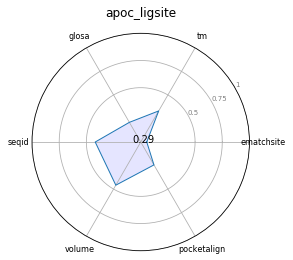

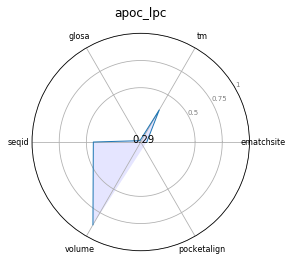

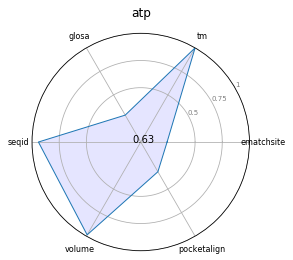

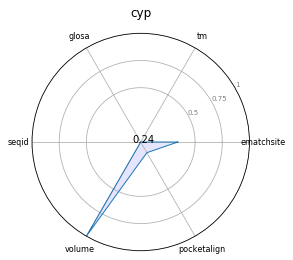

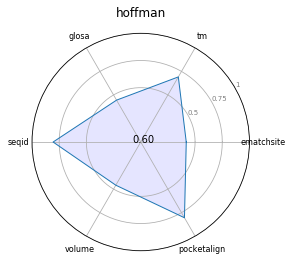

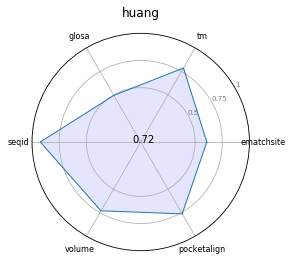

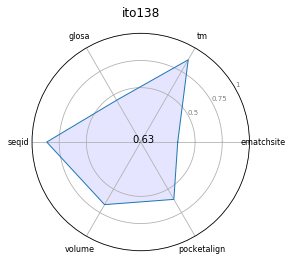

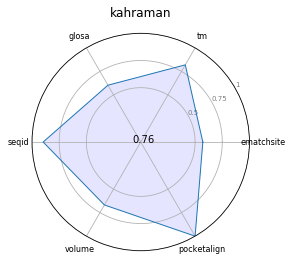

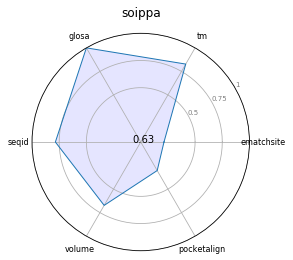

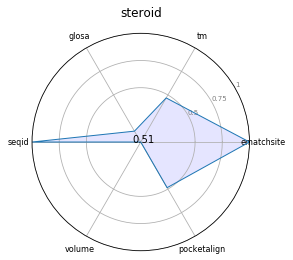

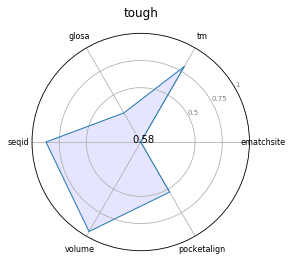

In [153]:

for dset in df_normalized.index:
    # 1 - df b/c we want datasets 
    spider(1-df_normalized, dset)




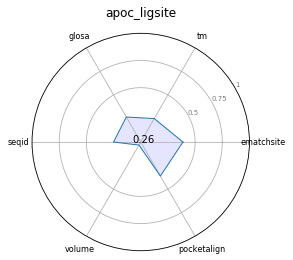

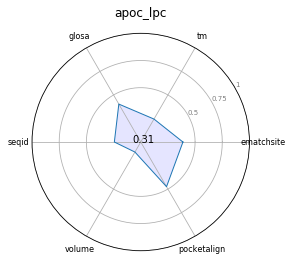

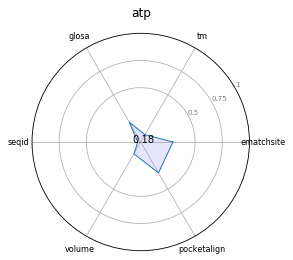

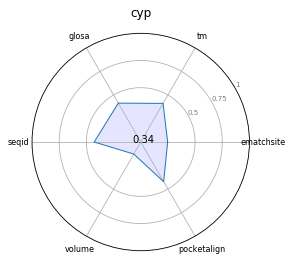

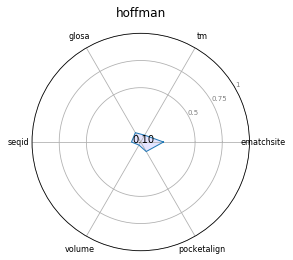

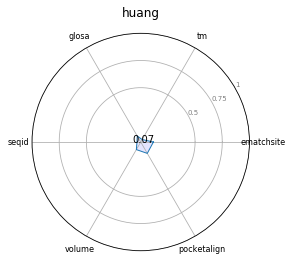

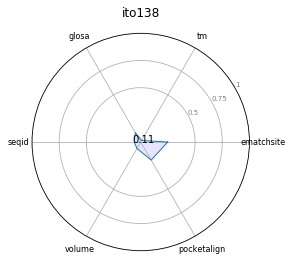

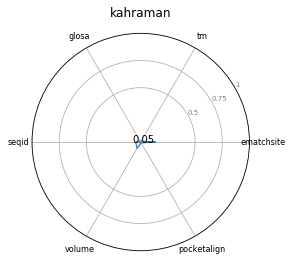

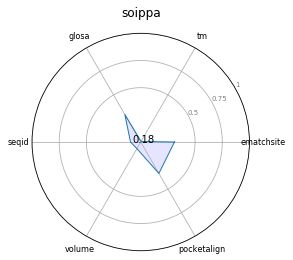

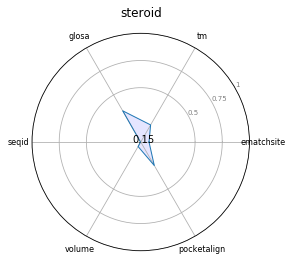

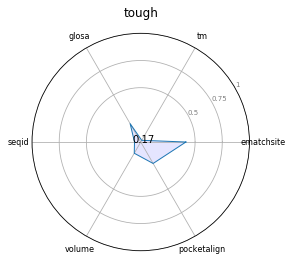

In [154]:
for dset in df.index:
    # 1 - df b/c we want datasets 
    spider(np.abs(roc_auc-0.5), dset)